<a href="https://colab.research.google.com/github/afgraciano/Proyecto_American_Express_Prediction/blob/main/01-An%C3%A1lisis%20de%20datos%2C%20modelos%20e%20interacciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ANALISIS DE LOS DATOS, MODELOS E INTERACCIONES

### La competencia de kaggle desde el siguiente enlace
https://www.kaggle.com/competitions/amex-default-prediction/data

Primero importamos las librerias necesarias

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier


Significado de las variables

- D_* = Delinquency variables
- S_* = Spend variables
- P_* = Payment variables
- B_* = Balance variables
- R_* = Risk variables

Estaremos trabajando con el archivo data_full.text, que es el archivo ya trabajado y con su tamaño drasticamente reducido.
Puedes obtenerlo directamente desde la siguiente linea

In [ ]:
#!wget -O data_full.txt "https://drive.google.com/uc?export=download&id=1tXL1hqY_att63Ss55o6_BCOqnx17VPqH"
!wget -O data_full.txt "https://drive.google.com/uc?export=download&id=1jZ_r3OvEXQgsjHxKeB-5qScQYRGUjz0E"


--2024-03-28 02:20:51--  https://drive.google.com/uc?export=download&id=1jZ_r3OvEXQgsjHxKeB-5qScQYRGUjz0E
Resolving drive.google.com (drive.google.com)... 142.250.157.100, 142.250.157.139, 142.250.157.101, ...
Connecting to drive.google.com (drive.google.com)|142.250.157.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1jZ_r3OvEXQgsjHxKeB-5qScQYRGUjz0E&export=download [following]
--2024-03-28 02:20:52--  https://drive.usercontent.google.com/download?id=1jZ_r3OvEXQgsjHxKeB-5qScQYRGUjz0E&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 108.177.97.132, 2404:6800:4008:c00::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|108.177.97.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17778398 (17M) [application/octet-stream]
Saving to: ‘data_full.txt’

data_full.txt       100%[===================>]  16.95M  36.3M

In [ ]:
df = pd.read_csv('data_full.txt', sep='\t')
df.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,000adf2938f771f75a581b65107024eddeae70684778c0...,2017-04-25,0.885999,0.009377,0.008894,1.006219,0.008716,0.065198,0.001650,0.009946,...,NaN,NaN,0.001505,0.009169,0.009822,NaN,0.004713,0.002896,0.002524,0
1,001a152e1893ab8372e7c9627c9de2e024399f2660d5d8...,2017-11-10,0.750890,0.037378,0.045959,1.001278,0.000312,0.087636,0.004212,0.001730,...,NaN,NaN,0.006351,0.001419,0.004957,NaN,0.001577,0.004017,0.007144,0
2,001e2ceaf1421f1477c0de9ba1c9357b9d278f7b670ab7...,2018-03-26,0.607227,0.002678,0.001271,0.812964,0.005415,NaN,0.005049,0.006548,...,NaN,NaN,0.008643,0.007299,0.000205,NaN,0.006518,0.008823,0.002062,1
3,0034f7e366a41d2500643c7dd0faa6302ce944743ccdf5...,2018-01-07,0.775546,0.003486,0.234352,0.040793,0.256024,0.172966,0.000081,0.225639,...,NaN,NaN,1.002720,0.008143,0.995023,0.626496,1.000037,0.671750,0.188801,0
4,00394e07aa3f71174f8bedfd16d64f194c80ad9445e17f...,2017-04-27,0.358659,0.001814,0.028545,1.004951,0.009079,0.765318,0.003546,0.009843,...,NaN,NaN,0.002115,0.004143,0.007057,NaN,0.004255,0.001370,0.007717,1


---

#### Miremos como está distribuido el DF, para ver cuantas variables categóricas tiene y que otros datos se pueden rescatar.
Buscamos que columnas son categóricas (Object) y procedemos a llenar sus campos faltantes con el dato anterior, según el DF estas deberían de ser:
**['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']**
pero solo dos de ellas no son numéricas, así que las dejaremos igual y solo aplicaremos la transformación a las de tipo objeto
Como las faltantes pertenecen al grupo **D_** procedemos a completarlas con la **moda**.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6041 entries, 0 to 6040
Columns: 191 entries, customer_ID to target
dtypes: float64(185), int64(2), object(4)
memory usage: 8.8+ MB


In [ ]:
column =  df.select_dtypes(include=['object']).columns.to_list()
sub_df = df[column]
print(column)

['customer_ID', 'S_2', 'D_63', 'D_64']


In [ ]:
sub_df.isna().sum()

customer_ID      0
S_2              0
D_63             0
D_64           232
dtype: int64

In [ ]:
df['D_64'].mode()[0]

'O'

In [ ]:
df['D_64'].fillna(df['D_64'].mode()[0], inplace=True)
sub_df = df[column]
sub_df.isna().sum()

customer_ID    0
S_2            0
D_63           0
D_64           0
dtype: int64

---
De las 4 columnas S_2 es una fecha, por lo tanto, no se tiene en cuenta, lo vamos a transformar como tal y customer_ID  es el ID único, en consecuencia tampoco, solo nos queda D_63 y D_64 viendo un poco más su contenido nos queda que son  Categóricas Nominales como resultado utilizaremos One-Hot Encoding para hacer su transformación, renombraremos el D_64-1 por D_64_I por comodidad

In [ ]:
df['S_2'] = pd.to_datetime(df['S_2'])

In [ ]:
df['D_63'].value_counts()

CO    4496
CR     999
CL     492
XZ      35
XM      12
XL       7
Name: D_63, dtype: int64

In [ ]:
df['D_64'].value_counts()

O     3422
U     1694
R      889
-1      36
Name: D_64, dtype: int64

In [ ]:
df = pd.get_dummies(df, columns=['D_63', 'D_64'])

In [ ]:
df.rename(columns={'D_64_-1': 'D_64_I'}, inplace=True)

In [ ]:
df[['D_63_CO', 'D_63_CR', 'D_63_CL', 'D_63_XZ', 'D_63_XZ', 'D_63_XM', 'D_63_XL', 'D_64_O', 'D_64_U', 'D_64_R',
    'D_64_I', 'target']]

,D_63_CO,D_63_CR,D_63_CL,D_63_XZ,D_63_XZ,D_63_XM,D_63_XL,D_64_O,D_64_U,D_64_R,D_64_I,target
0,1,0,0,0,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,0,0,1,0,0,0
2,1,0,0,0,0,0,0,1,0,0,0,1
3,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6036,1,0,0,0,0,0,0,0,1,0,0,0
6037,1,0,0,0,0,0,0,0,1,0,0,1
6038,1,0,0,0,0,0,0,0,0,1,0,1
6039,1,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
def completar_na(sub_df):
    for colum in sub_df.columns:
        df[colum].fillna(df[colum].mode()[0], inplace=True)

---
Prosigamos con el resto de categóricas con la **moda**.
**['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_66', 'D_68']**
Dado que se presentan valores atípicos

In [ ]:
category = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_66', 'D_68']

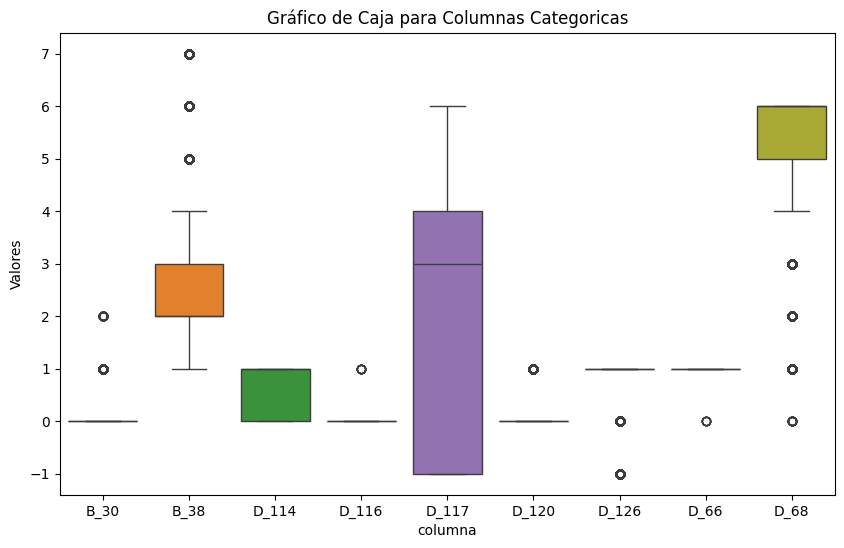

In [ ]:
columnas_C = df[category]

plt.figure(figsize=(10, 6))
sns.boxplot(data=columnas_C, orient='v')
plt.title('Gráfico de Caja para Columnas Categoricas')
plt.ylabel('Valores')
plt.xlabel('columna')
plt.show()

In [ ]:
sub_df = df[category]
sub_df.isna().sum()

B_30        3
B_38        3
D_114     183
D_116     183
D_117     183
D_120     183
D_126     115
D_66     5383
D_68      228
dtype: int64

In [ ]:
completar_na(sub_df)

sub_df = df[category]
sub_df.isna().sum()

B_30     0
B_38     0
D_114    0
D_116    0
D_117    0
D_120    0
D_126    0
D_66     0
D_68     0
dtype: int64

---
Ahora analicemos el resto de los grupos faltantes:

### S_*

In [ ]:
columnas_S = df.filter(like='S_').drop('S_2', axis=1)

sub_df = df[columnas_S.columns].loc[:, df[columnas_S.columns].isna().any()]
sub_df.isna().sum()

S_3     1167
S_7     1167
S_9     3226
S_22      28
S_23       1
S_24      27
S_25      16
S_26       1
S_27    1579
dtype: int64

<Figure size 1000x600 with 0 Axes>

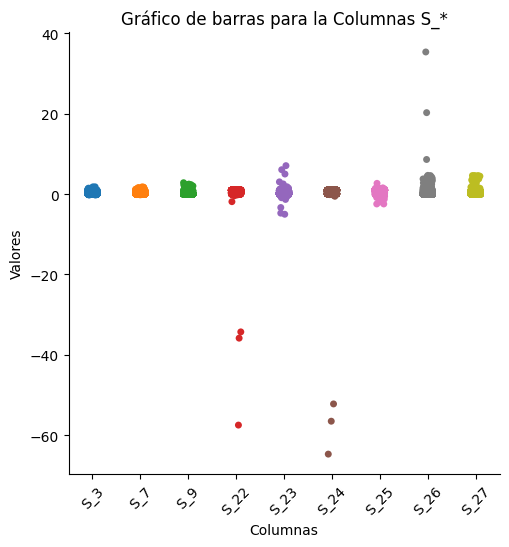

In [ ]:
plt.figure(figsize=(10, 6))  # Ajusta el tamaño de la figura

sns.catplot(data = sub_df)
plt.title('Gráfico de barras para la Columnas S_*')
plt.ylabel('Valores')
plt.xlabel('Columnas')
plt.xticks(rotation=45)  # Rota los nombres de las columnas si es necesario
plt.show()

In [ ]:
completar_na(sub_df)

### D_*

In [ ]:
columnas_D = df.filter(like='D_')

sub_df = df[columnas_D.columns].loc[:, df[columnas_D.columns].isna().any()]
sub_df.isna().sum()

D_41        3
D_42     5164
D_43     1811
D_44      315
D_45        3
         ... 
D_141     103
D_142    5007
D_143     103
D_144      41
D_145     103
Length: 73, dtype: int64

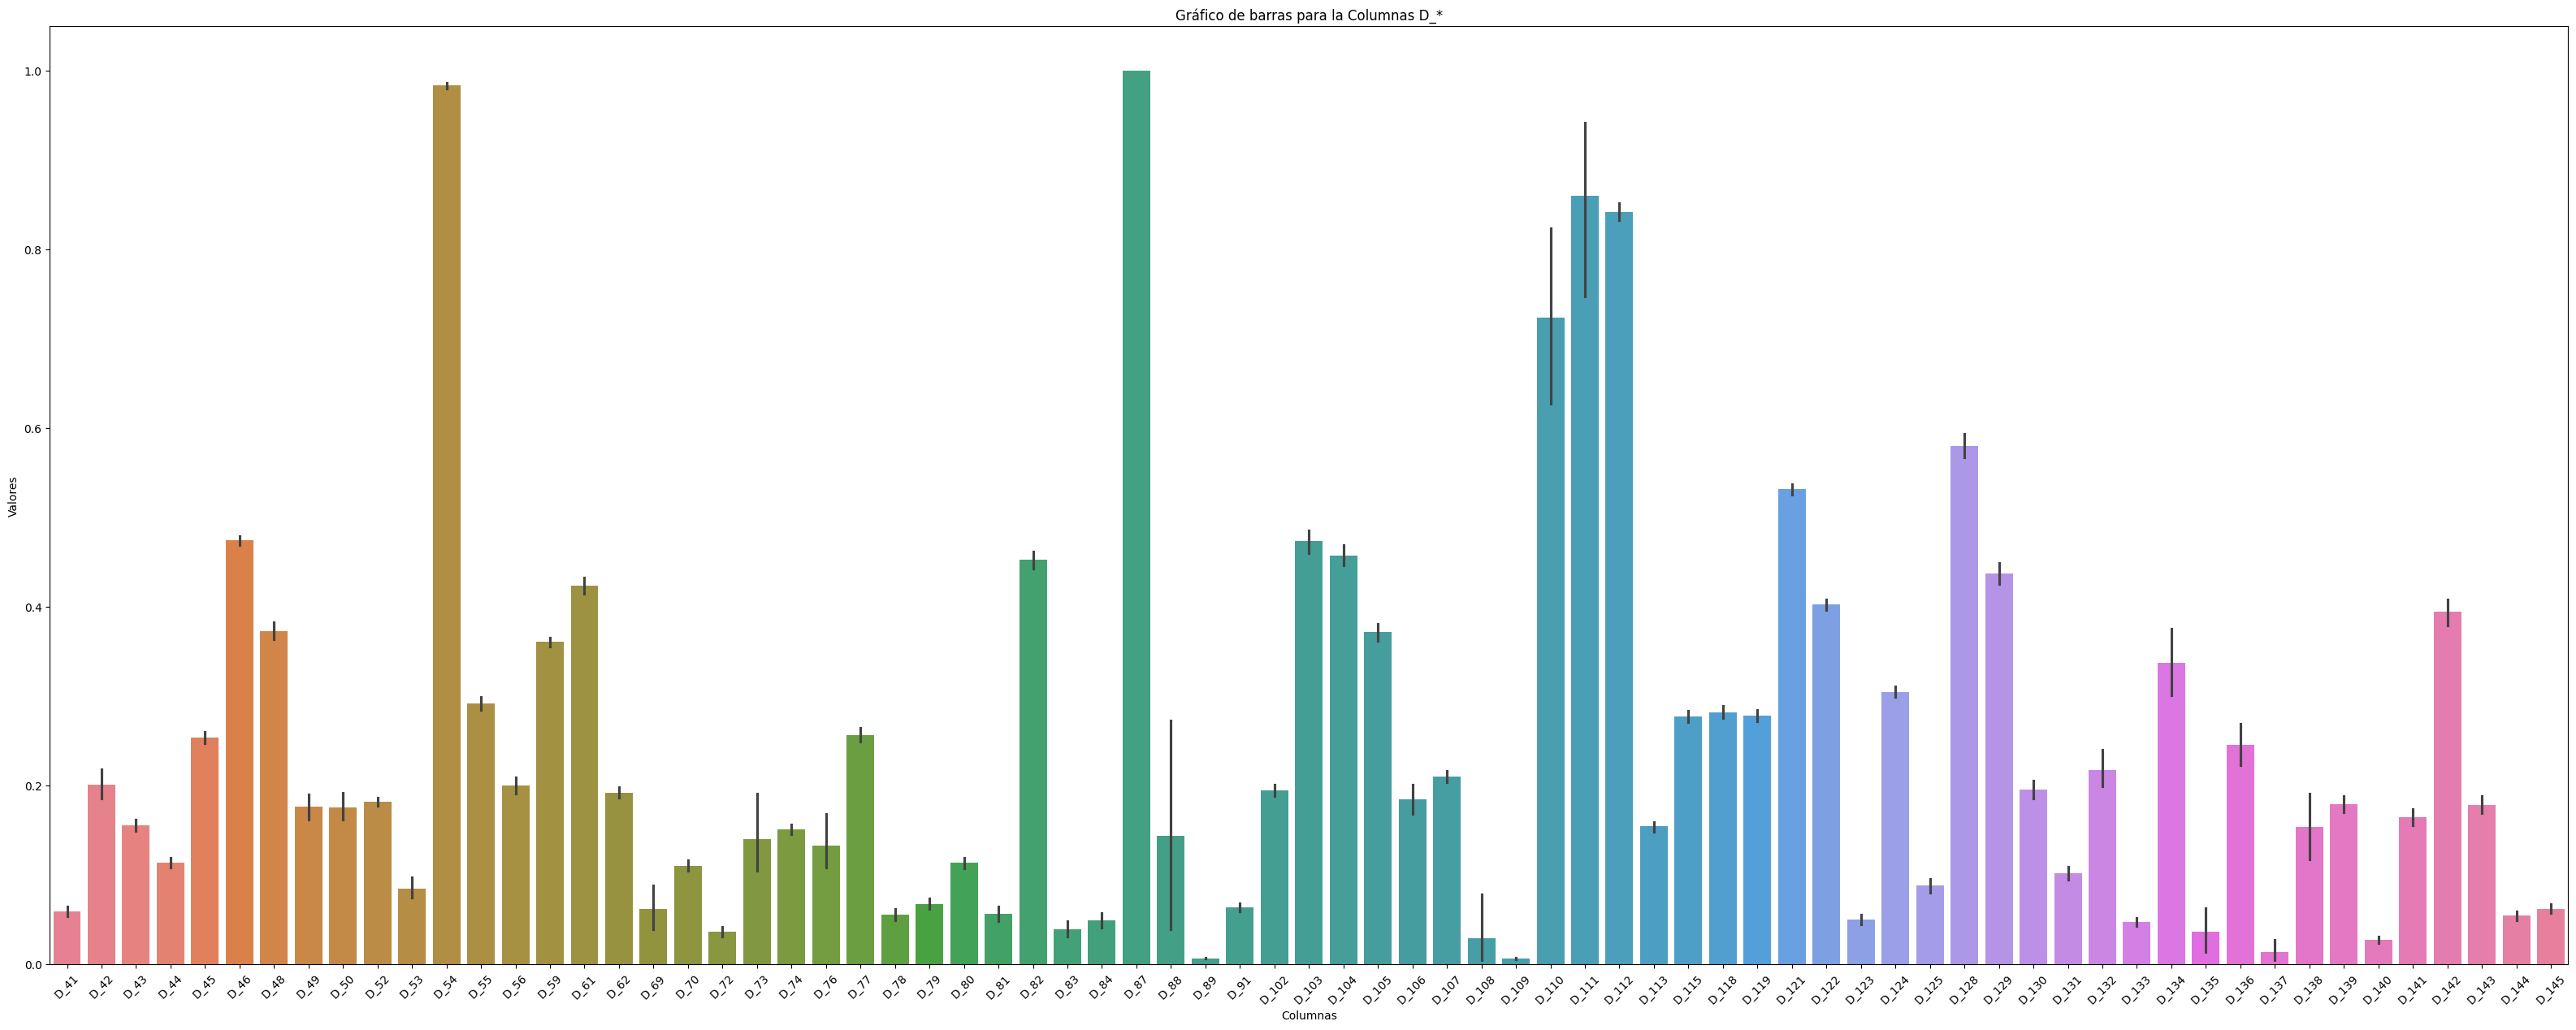

In [ ]:
plt.figure(figsize=(40, 15))  # Ajusta el tamaño de la figura
sns.barplot(data = sub_df)
plt.title('Gráfico de barras para la Columnas D_*')
plt.ylabel('Valores')
plt.xlabel('Columnas')
plt.xticks(rotation=45)  # Rota los nombres de las columnas si es necesario
plt.show()

In [ ]:
completar_na(sub_df)

### P_*

In [ ]:
columnas_P = df.filter(like='P_')

sub_df = df[columnas_P.columns].loc[:, df[columnas_P.columns].isna().any()]
sub_df.isna().sum()

P_2     50
P_3    307
dtype: int64

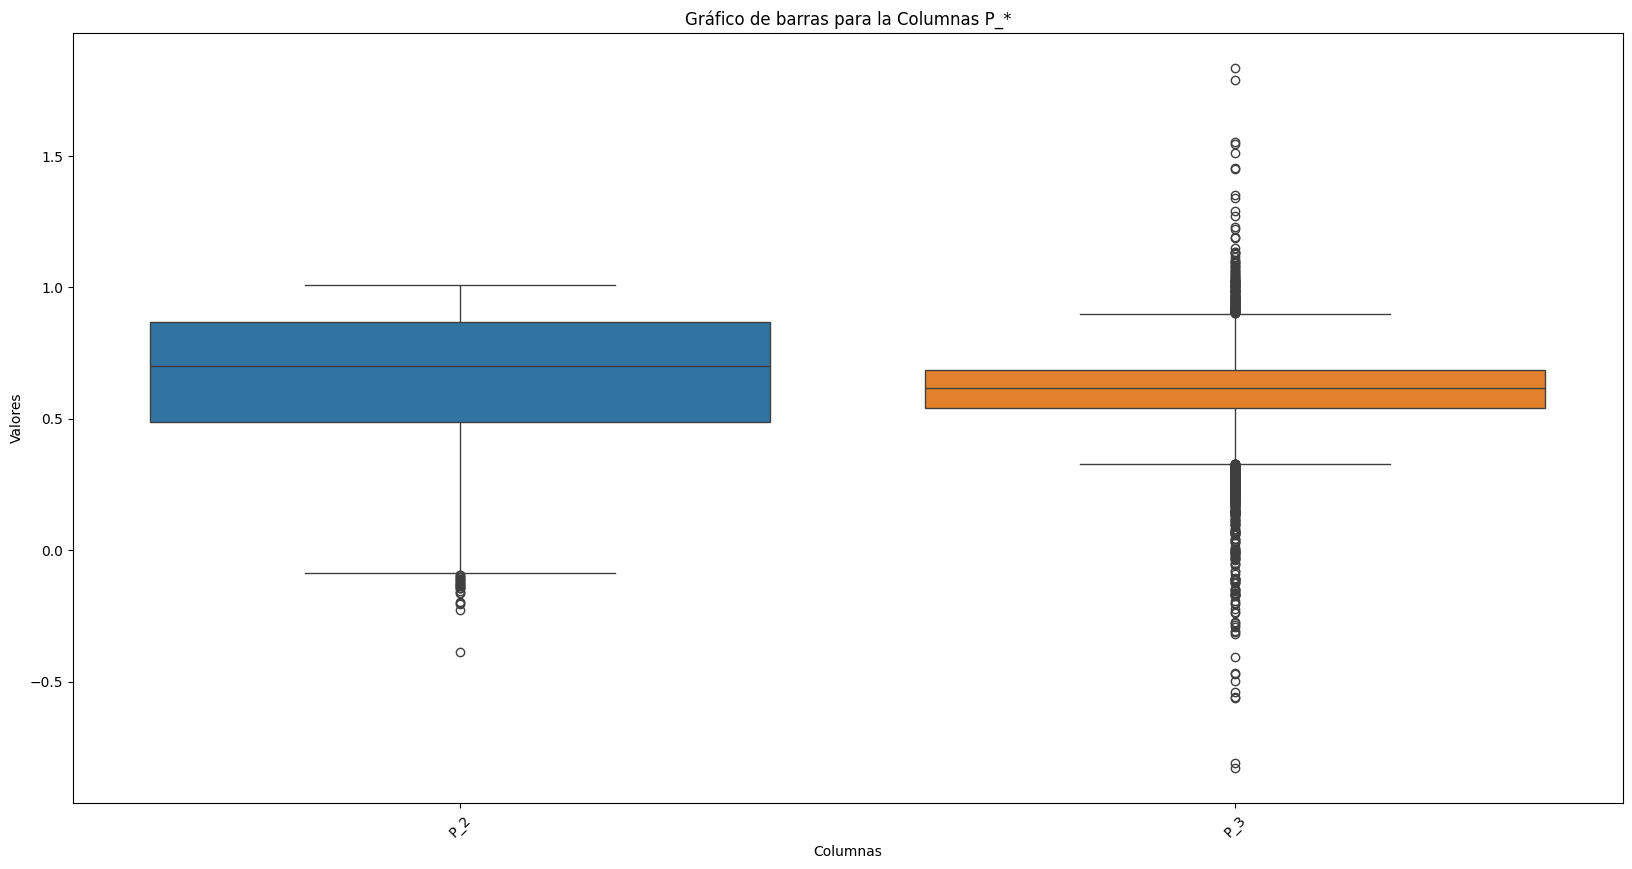

In [ ]:
plt.figure(figsize=(20, 10))  # Ajusta el tamaño de la figura
sns.boxplot(data = sub_df)
plt.title('Gráfico de barras para la Columnas P_*')
plt.ylabel('Valores')
plt.xlabel('Columnas')
plt.xticks(rotation=45)  # Rota los nombres de las columnas si es necesario
plt.show()

In [ ]:
completar_na(sub_df)

### B_*

In [ ]:
columnas_B = df.filter(like='B_')

sub_df = df[columnas_B.columns].loc[:, df[columnas_B.columns].isna().any()]
sub_df.isna().sum()

B_2        3
B_3        3
B_8       32
B_13      35
B_15      10
B_16       3
B_17    3526
B_19       3
B_20       3
B_22       3
B_25      10
B_26       3
B_27       3
B_29    5623
B_33       3
B_39    6009
B_41       1
B_42    5960
dtype: int64

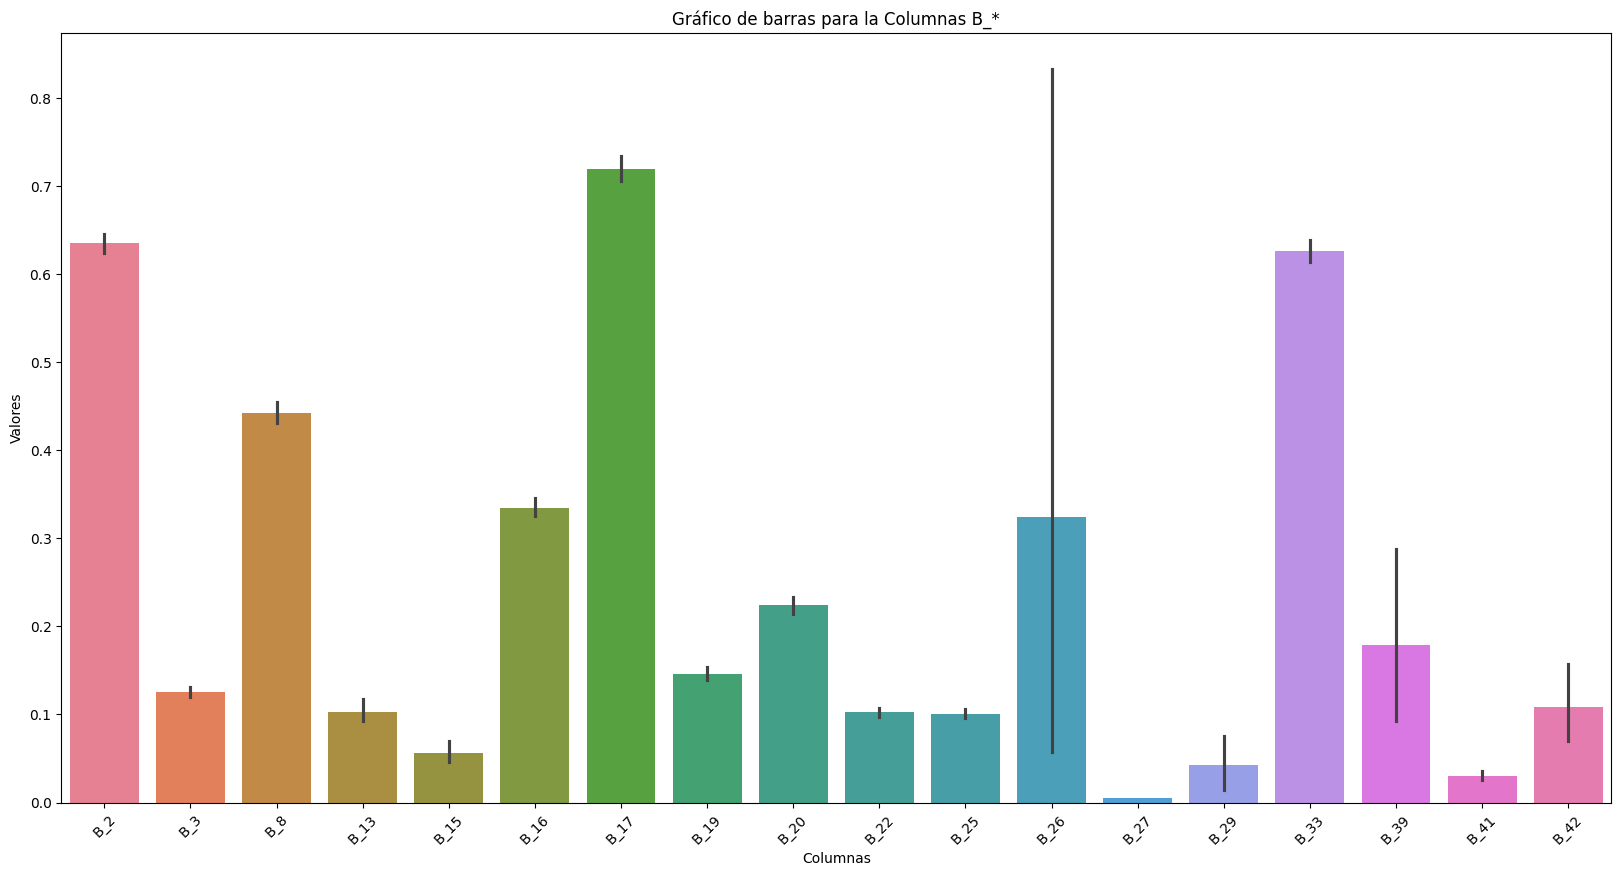

In [ ]:
plt.figure(figsize=(20, 10))  # Ajusta el tamaño de la figura
sns.barplot(data = sub_df)
plt.title('Gráfico de barras para la Columnas B_*')
plt.ylabel('Valores')
plt.xlabel('Columnas')
plt.xticks(rotation=45)  # Rota los nombres de las columnas si es necesario
plt.show()

In [ ]:
completar_na(sub_df)

### R_*

In [ ]:
columnas_R = df.filter(like='R_')

sub_df = df[columnas_R.columns].loc[:, df[columnas_R.columns].isna().any()]
sub_df.isna().sum()

R_9     5720
R_26    5402
R_27     149
dtype: int64

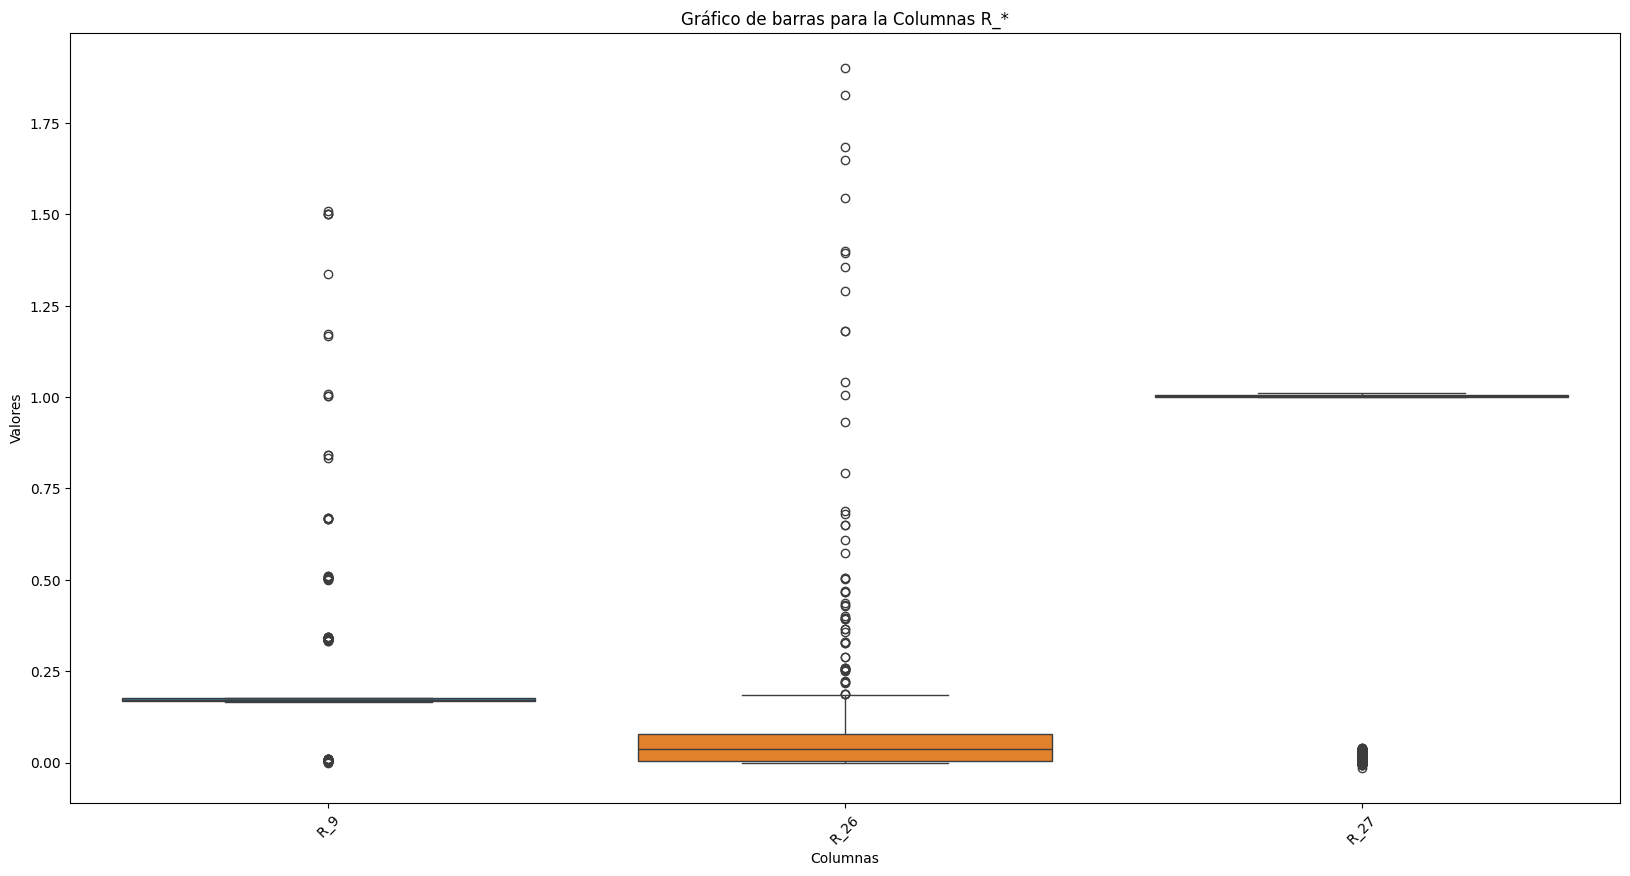

In [ ]:
plt.figure(figsize=(20, 10))  # Ajusta el tamaño de la figura
sns.boxplot(data = sub_df)
plt.title('Gráfico de barras para la Columnas R_*')
plt.ylabel('Valores')
plt.xlabel('Columnas')
plt.xticks(rotation=45)  # Rota los nombres de las columnas si es necesario
plt.show()

In [ ]:
completar_na(sub_df)

In [ ]:
print(f'Informacion faltate en el DF: {df.isna().sum().sum()}')

Informacion faltate en el DF: 0


## Modelos

In [ ]:
# Separar las características (X) y la variable objetivo (y)
X = df.drop('target', axis=1)  # Quitamos la columna 'target' del DataFrame para obtener las características
y = df['target']  # Columna 'target' como variable objetivo

# Dividir el conjunto de datos en entrenamiento y prueba (por ejemplo, 70-30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [ ]:
# 'customer_ID' es una variable categórica y 'S_2' es una variable de tipo fecha

# Codificar 'customer_ID' usando Label Encoding

label_encoder = LabelEncoder()
df['customer_ID_encoded'] = label_encoder.fit_transform(df['customer_ID'])

# Tratamiento de la variable de fecha 'S_2'
df['S_2'] = pd.to_datetime(df['S_2'])  # Convertir a tipo datetime
df['year'] = df['S_2'].dt.year  # Extraer el año
df['month'] = df['S_2'].dt.month  # Extraer el mes

# Eliminar las columnas originales 'customer_ID' y 'S_2' que ya no son necesarias
df.drop(['customer_ID', 'S_2'], axis=1, inplace=True)

# Separar las características (X) y la variable objetivo (y)
X = df.drop('target', axis=1)  # Quitamos la columna 'target' del DataFrame para obtener las características
y = df['target']  # Columna 'target' como variable objetivo

# Dividir el conjunto de datos en entrenamiento y prueba (por ejemplo, 70-30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Inicializar los modelos
logistic_regression = LogisticRegression()
random_forest = RandomForestClassifier()
svm_classifier = SVC()

In [ ]:
# Entrenar los modelos
logistic_regression.fit(X_train, y_train)
random_forest.fit(X_train, y_train)
svm_classifier.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


SVC()

In [ ]:
# Predicciones en el conjunto de prueba
y_pred_lr = logistic_regression.predict(X_test)

# Métricas de evaluación
print("Logistic Regression Metrics:")
print(classification_report(y_test, y_pred_lr))
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_lr))

Logistic Regression Metrics:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92      1385
           1       0.75      0.67      0.71       428

    accuracy                           0.87      1813
   macro avg       0.83      0.80      0.81      1813
weighted avg       0.87      0.87      0.87      1813

Accuracy: 0.8692774407060121
ROC AUC Score: 0.7998161206518438


In [ ]:
# Predicciones en el conjunto de prueba
y_pred_rf = random_forest.predict(X_test)


# Métricas de evaluación
print("Random Forest Metrics:")
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_rf))

Random Forest Metrics:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92      1385
           1       0.75      0.67      0.70       428

    accuracy                           0.87      1813
   macro avg       0.82      0.80      0.81      1813
weighted avg       0.86      0.87      0.87      1813

Accuracy: 0.8681742967457253
ROC AUC Score: 0.7982868855224534


In [ ]:
# Predicciones en el conjunto de prueba
y_pred_svm = svm_classifier.predict(X_test)

# Métricas de evaluación
print("SVM Metrics:")
print(classification_report(y_test, y_pred_svm))
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_svm))

SVM Metrics:
              precision    recall  f1-score   support

           0       0.76      1.00      0.87      1385
           1       0.00      0.00      0.00       428

    accuracy                           0.76      1813
   macro avg       0.38      0.50      0.43      1813
weighted avg       0.58      0.76      0.66      1813

Accuracy: 0.7639271924986211
ROC AUC Score: 0.5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Hiperparámetros

### Random Forest

In [ ]:

# Definir los hiperparámetros a ajustar
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
}

# Realizar búsqueda grid para RandomForestClassifier
grid_search_rf = GridSearchCV(random_forest, param_grid_rf, cv=5, scoring='roc_auc')
grid_search_rf.fit(X_train, y_train)

# Mostrar los mejores parámetros y el mejor score
print("Best Parameters for RandomForest:", grid_search_rf.best_params_)
print("Best ROC AUC Score for RandomForest:", grid_search_rf.best_score_)

Best Parameters for RandomForest: {'max_depth': 20, 'n_estimators': 300}
Best ROC AUC Score for RandomForest: 0.9264815493652099


In [ ]:
# Crear un clasificador RandomForest con los mejores hiperparámetros encontrados
best_random_forest = RandomForestClassifier(max_depth=None, n_estimators=300)

# Entrenar el modelo con los datos de entrenamiento
best_random_forest.fit(X_train, y_train)

# Predecir utilizando el modelo entrenado
predictions = best_random_forest.predict(X_test)

# Evaluar el rendimiento del modelo

accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)

print(f"Precisión del modelo: {accuracy}")
print(f"Reporte de clasificación:\n{report}")


Precisión del modelo: 0.8659680088251517
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91      1385
           1       0.74      0.67      0.70       428

    accuracy                           0.87      1813
   macro avg       0.82      0.80      0.81      1813
weighted avg       0.86      0.87      0.86      1813



In [ ]:


# Obtener predicciones y probabilidades del modelo de bosque aleatorio
y_pred_rf = best_random_forest.predict(X_test)
y_pred_proba_rf = best_random_forest.predict_proba(X_test)[:, 1]

# Calcular métricas
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)
rf_roc_auc = roc_auc_score(y_test, y_pred_proba_rf)
rf_conf_matrix = confusion_matrix(y_test, y_pred_rf)

# Imprimir las métricas
print("Random Forest Metrics:")
print("Accuracy:", rf_accuracy)
print("Precision:", rf_precision)
print("Recall:", rf_recall)
print("ROC AUC Score:", rf_roc_auc)
print("Confusion Matrix:")
print(rf_conf_matrix)

Random Forest Metrics:
Accuracy: 0.8659680088251517
Precision: 0.7365728900255755
Recall: 0.6728971962616822
ROC AUC Score: 0.9261749721650528
Confusion Matrix:
[[1282  103]
 [ 140  288]]


### Logistic Regression

In [ ]:
# Define el modelo de regresión logística
logistic_regression = LogisticRegression(max_iter=10000)

# Define el espacio de búsqueda de hiperparámetros
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Valores para la fuerza de regularización
    'penalty': ['l1', 'l2'],  # Tipo de regularización (L1 o L2)
}

# Realiza una búsqueda grid para encontrar los mejores hiperparámetros
grid_search = GridSearchCV(logistic_regression, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Muestra los mejores parámetros y el mejor score
print("Best Parameters for Logistic Regression:", grid_search.best_params_)
print("Best Accuracy Score for Logistic Regression:", grid_search.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solve

Best Parameters for Logistic Regression: {'C': 0.1, 'penalty': 'l2'}
Best Accuracy Score for Logistic Regression: 0.8710996404940758


In [ ]:
# Definir el modelo de regresión logística con los mejores parámetros encontrados
best_logistic_regression = LogisticRegression(C=0.1, penalty='l2', max_iter=10000)

# Entrenar el modelo con los mejores parámetros utilizando todo el conjunto de entrenamiento
best_logistic_regression.fit(X_train, y_train)

# Evaluar el modelo en el conjunto de prueba (X_test, y_test)
accuracy = best_logistic_regression.score(X_test, y_test)
print("Accuracy of the Best Logistic Regression model:", accuracy)


Accuracy of the Best Logistic Regression model: 0.8643132928847215


In [ ]:


# Realizar predicciones en el conjunto de prueba
y_pred = best_logistic_regression.predict(X_test)
y_pred_proba = best_logistic_regression.predict_proba(X_test)[:, 1]

# Calcular y mostrar diferentes métricas
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

# Calcular y mostrar la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

Accuracy: 0.8643132928847215
Precision: 0.7407407407407407
Recall: 0.6542056074766355
ROC AUC Score: 0.9212507169607611

Confusion Matrix:
[[1287   98]
 [ 148  280]]


### XGBoost

In [ ]:
# Definir el modelo XGBoost
xgb_model = xgb.XGBClassifier()

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 300],  # Lista de valores para el número de árboles
    'max_depth': [3, 5, 7],  # Lista de valores para la profundidad máxima del árbol
    'learning_rate': [0.1, 0.01, 0.001]  # Lista de valores para la tasa de aprendizaje
}

# Inicializar GridSearchCV con el modelo XGBoost y el espacio de hiperparámetros
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='accuracy')

# Realizar la búsqueda de hiperparámetros utilizando los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

Mejores hiperparámetros: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


In [ ]:
# Utilizar los mejores hiperparámetros para el modelo XGBoost
best_xgb_model = xgb.XGBClassifier(**best_params)

# Entrenar el modelo con los mejores hiperparámetros
best_xgb_model.fit(X_train, y_train)


# Predecir utilizando el modelo entrenado
predictions = best_xgb_model.predict(X_test)

# Evaluar el rendimiento del modelo

accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)

print(f"Precisión del modelo: {accuracy}")
print(f"Reporte de clasificación:\n{report}")

# Realizar predicciones y evaluar el modelo con los datos de prueba
y_pred_xgb = best_xgb_model.predict(X_test)
y_pred_proba_xgb = best_xgb_model.predict_proba(X_test)[:, 1]

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)

# Imprimir las métricas
print("XGBoost Metrics:")
print("Accuracy:", accuracy_xgb)
print("Precision:", precision_xgb)
print("Recall:", recall_xgb)
print("ROC AUC Score:", roc_auc_xgb)

Precisión del modelo: 0.8720353006067292
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.91      0.92      0.92      1385
           1       0.74      0.71      0.72       428

    accuracy                           0.87      1813
   macro avg       0.82      0.82      0.82      1813
weighted avg       0.87      0.87      0.87      1813

XGBoost Metrics:
Accuracy: 0.8720353006067292
Precision: 0.7390243902439024
Recall: 0.7079439252336449
ROC AUC Score: 0.9296956712439691


### PCA-Random Forest

In [ ]:
# Definir el modelo de PCA
pca = PCA()

# Definir el modelo de Random Forest
rf = RandomForestClassifier()

# Crear el pipeline combinando PCA y RandomForestClassifier
pipeline = Pipeline([
    ('pca', pca),
    ('rf', rf)
])

# Definir los parámetros a ajustar en GridSearchCV
param_grid = {
    'pca__n_components': [5, 10, 20],  # Ajustar el número de componentes principales
    'rf__n_estimators': [50, 100, 200],  # Ajustar el número de árboles en el RandomForest
    'rf__max_depth': [None, 10, 20]  # Ajustar la profundidad máxima de los árboles
}

# Realizar la búsqueda de hiperparámetros con GridSearchCV
grid = GridSearchCV(pipeline, param_grid=param_grid, cv=3)
grid.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid.best_params_)


Mejores hiperparámetros: {'pca__n_components': 20, 'rf__max_depth': 10, 'rf__n_estimators': 50}


In [ ]:
# Crear el modelo con los mejores hiperparámetros encontrados
best_pca_components = grid.best_params_['pca__n_components']
best_rf_estimators = grid.best_params_['rf__n_estimators']
best_rf_depth = grid.best_params_['rf__max_depth']

# Definir el modelo de PCA con los mejores hiperparámetros
best_pca = PCA(n_components=best_pca_components)

# Definir el modelo de RandomForest con los mejores hiperparámetros
best_rf = RandomForestClassifier(n_estimators=best_rf_estimators, max_depth=best_rf_depth)

# Crear el pipeline combinando PCA y RandomForestClassifier con los mejores hiperparámetros
best_pipeline = Pipeline([
    ('pca', best_pca),
    ('rf', best_rf)
])

# Entrenar el modelo con los datos de entrenamiento
best_pipeline.fit(X_train, y_train)


Pipeline(steps=[('pca', PCA(n_components=20)),
                ('rf', RandomForestClassifier(max_depth=10, n_estimators=50))])

In [ ]:
# Realizar predicciones en el conjunto de prueba
y_pred = best_pipeline.predict(X_test)

# Evaluar el rendimiento del modelo

# Calcular la precisión
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Mostrar otros resultados
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.8411472697186982
Confusion Matrix:
[[1292   93]
 [ 195  233]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      1385
           1       0.71      0.54      0.62       428

    accuracy                           0.84      1813
   macro avg       0.79      0.74      0.76      1813
weighted avg       0.83      0.84      0.83      1813



### PCA-XGBoost

In [ ]:
# Definir el modelo de PCA
pca = PCA()

# Definir el modelo de XGBoost
xgb = XGBClassifier()

# Crear el pipeline combinando PCA y XGBoost
pipeline = Pipeline([
    ('pca', pca),
    ('xgb', xgb)
])

# Definir los parámetros a ajustar en GridSearchCV
param_grid = {
    'pca__n_components': [5, 10, 20],  # Ajustar el número de componentes principales
    'xgb__n_estimators': [50, 100, 200],  # Ajustar el número de estimadores en XGBoost
    'xgb__max_depth': [3, 5, 7]  # Ajustar la profundidad máxima de los árboles en XGBoost
}

# Realizar la búsqueda de hiperparámetros con GridSearchCV
grid = GridSearchCV(pipeline, param_grid=param_grid, cv=3)
grid.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid.best_params_)


Mejores hiperparámetros: {'pca__n_components': 20, 'xgb__max_depth': 5, 'xgb__n_estimators': 100}


In [ ]:
# Definir el modelo de PCA con los mejores hiperparámetros encontrados
best_pca_components = grid.best_params_['pca__n_components']
best_pca = PCA(n_components=best_pca_components)

# Definir el modelo de XGBoost con los mejores hiperparámetros encontrados
best_xgb_estimators = grid.best_params_['xgb__n_estimators']
best_xgb_depth = grid.best_params_['xgb__max_depth']
best_xgb = XGBClassifier(n_estimators=best_xgb_estimators, max_depth=best_xgb_depth)

# Crear el pipeline combinando PCA y XGBoost con los mejores hiperparámetros
best_pipeline = Pipeline([
    ('pca', best_pca),
    ('xgb', best_xgb)
])

# Entrenar el modelo con los datos de entrenamiento
best_pipeline.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = best_pipeline.predict(X_test)

# Evaluar el rendimiento del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Mostrar otros resultados (matriz de confusión, reporte de clasificación, etc.)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.8571428571428571
Confusion Matrix:
[[1281  104]
 [ 155  273]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.91      1385
           1       0.72      0.64      0.68       428

    accuracy                           0.86      1813
   macro avg       0.81      0.78      0.79      1813
weighted avg       0.85      0.86      0.85      1813



## CURVAS DE APRENDIZAJE

### Logistic Regression


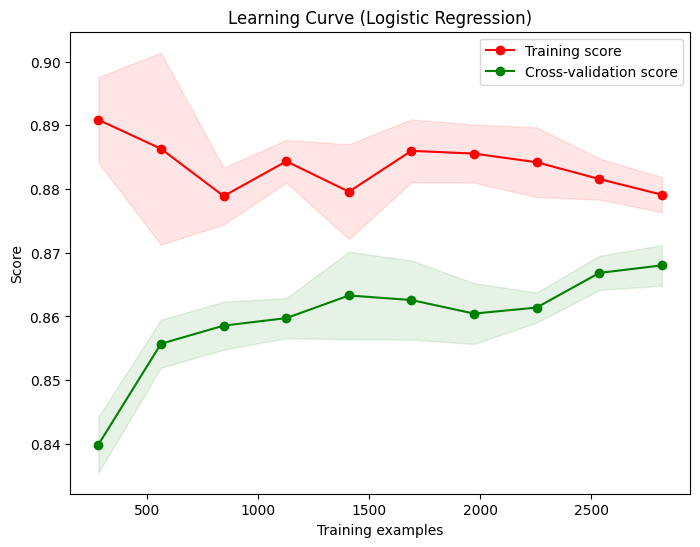

In [ ]:
# Definir tamaños de conjunto de datos para las curvas de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(best_logistic_regression, X_train, y_train, cv=3,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        scoring='accuracy')

# Calcular la media y desviación estándar de las puntuaciones
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Graficar las curvas de aprendizaje
plt.figure(figsize=(8, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.title("Learning Curve (Logistic Regression)")
plt.show()


### Random Forest

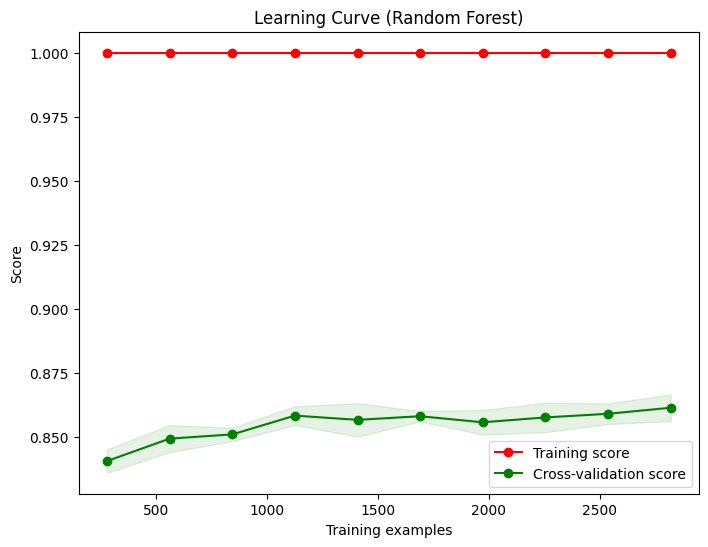

In [ ]:

# Definir tamaños de conjunto de datos para las curvas de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(best_random_forest, X_train, y_train, cv=3,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        scoring='accuracy')

# Calcular la media y desviación estándar de las puntuaciones
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Graficar las curvas de aprendizaje
plt.figure(figsize=(8, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.title("Learning Curve (Random Forest)")
plt.show()


### XGBoost

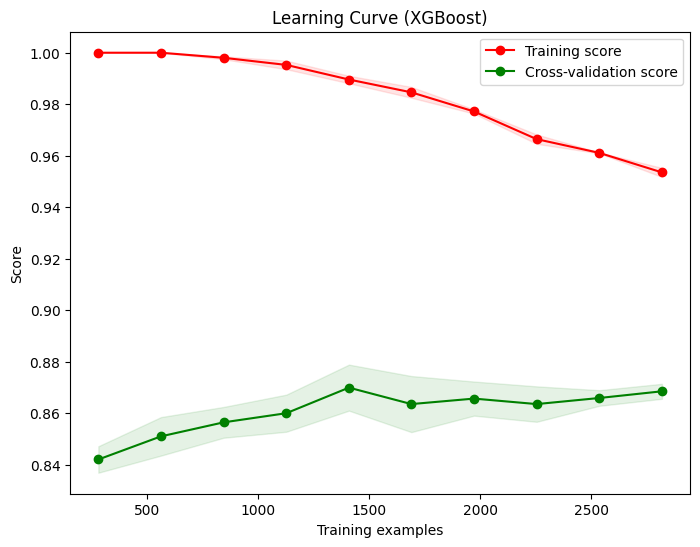

In [ ]:
# Definir tamaños de conjunto de datos para las curvas de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(best_xgb_model, X_train, y_train, cv=3,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        scoring='accuracy')

# Calcular la media y desviación estándar de las puntuaciones
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Graficar las curvas de aprendizaje
plt.figure(figsize=(8, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.title("Learning Curve (XGBoost)")
plt.show()


### PCA-Random Forest

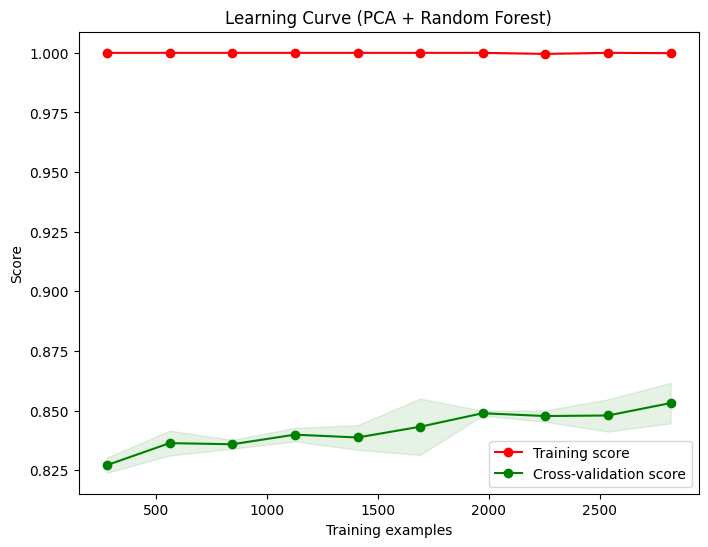

In [ ]:
# Definir tamaños de conjunto de datos para las curvas de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(best_pipeline, X_train, y_train, cv=3,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        scoring='accuracy')

# Calcular la media y desviación estándar de las puntuaciones
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Graficar las curvas de aprendizaje
plt.figure(figsize=(8, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.title("Learning Curve (PCA + Random Forest)")
plt.show()


### PCA-XGBoost

In [ ]:
# Definir tamaños de conjunto de datos para las curvas de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(best_pipeline, X_train, y_train, cv=3,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        scoring='accuracy')

# Calcular la media y desviación estándar de las puntuaciones
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Graficar las curvas de aprendizaje
plt.figure(figsize=(8, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.title("Learning Curve (PCA + XGBoost)")
plt.show()


Si desea ver las impresiones y recomendaciones acerca de las curvas de aprendizaje, ademas de las consideraciones de despliegue, por favor visite el informe completo en el siguiente enlace:

Muchas gracias